In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {c : i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i : c for c, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, y = [], []
    for w in words:
        context = [0] * block_size
        #print(w)
        for c in w + '.':
            X.append(context)
            y.append(stoi[c])
            context = context[1:] + [stoi[c]]
            #print(f"{''.join([itos[i] for i in context])} ==> {c}")
    #print("X:", X, "=>", " y:", y)
    X = torch.tensor(X)
    y = torch.tensor(y)
    print(X.shape, y.shape)
    return X, y


random.seed(2023)
random.shuffle(words)
n_train = int(0.8*len(words))
n_eval = int(0.9*len(words))

X_train, y_train = build_dataset(words[:n_train])
X_eval, y_eval = build_dataset(words[n_train:n_eval])
X_test, y_test = build_dataset(words[n_eval:])

torch.Size([182466, 3]) torch.Size([182466])
torch.Size([22839, 3]) torch.Size([22839])
torch.Size([22841, 3]) torch.Size([22841])


In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

n_embd = 10    # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of nureons in hidden layer of the MLP

C = torch.randn((vocab_size, n_embd), generator=g) # 1 is '.'
W1 = torch.randn((block_size*n_embd, n_hidden), generator=g) * (5/3) / (n_embd*block_size) ** 0.5 # kaiming init
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # need to calculate every char's probability, so the output dim shoulde be 27
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

print('W1.shape:', W1.shape)
print('b1.shape:', b1.shape)
print('W2.shape:', W2.shape)
print('b2.shape:', b2.shape)

W1.shape: torch.Size([30, 200])
b1.shape: torch.Size([200])
W2.shape: torch.Size([200, 27])
b2.shape: torch.Size([27])


In [31]:
sum(p.nelement() for p in parameters) # number of parameters in total

12097

In [32]:
epochs = 200000
batch_size = 32

In [33]:
lre = torch.linspace(-3, 0, epochs)
lrs = 10**lre

In [34]:
lri = [] # learning rate
lossi = []

In [35]:
for i in range(epochs):
    # minbatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, )) # random select batch_size indices
    Xb, yb = X_train[ix], y_train[ix] # bach X, y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
    
    # Linear layer
    h_pre_act = emb_cat @ W1 # + b1 # hidden layer pre-activation
    
    # BatchNorm layer
    #----------------------------------------------------------------
    bnmeani = h_pre_act.mean(0, keepdim=True)
    bnstdi = h_pre_act.std(0, keepdim=True)
    h_pre_act = bngain * (h_pre_act - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #----------------------------------------------------------------
    
    # Non-linearity
    h = torch.tanh(h_pre_act) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, yb) # loss function
#     counts = logits.exp()
#     probs = counts / counts.sum(1, keepdims=True)
#     loss = -probs[torch.arange(batch_size), y_train[ix]].log().mean() # negative log likelyhood
    #print(loss.item())
    
    # backward propagate
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track states
    #lri.append(lr)
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    #lossi.append(loss.item())
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
print(loss.item())

      0/ 200000: 3.3038
  10000/ 200000: 2.5931
  20000/ 200000: 2.2070
  30000/ 200000: 2.2625
  40000/ 200000: 2.5528
  50000/ 200000: 1.9592
  60000/ 200000: 2.1368
  70000/ 200000: 2.1095
  80000/ 200000: 2.2664
  90000/ 200000: 2.1130
 100000/ 200000: 1.7908
 110000/ 200000: 1.8225
 120000/ 200000: 1.7494
 130000/ 200000: 1.8060
 140000/ 200000: 2.4633
 150000/ 200000: 2.2372
 160000/ 200000: 2.1040
 170000/ 200000: 2.1819
 180000/ 200000: 1.8797
 190000/ 200000: 2.1253
2.1278810501098633


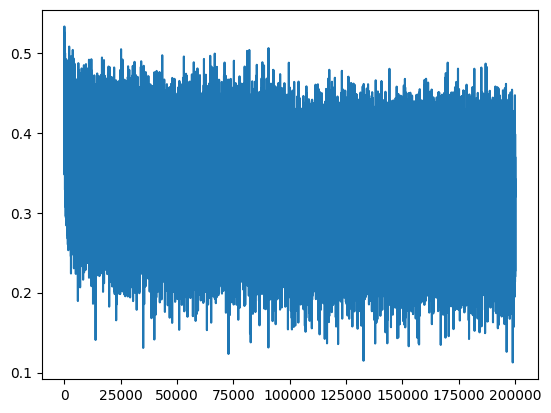

In [37]:
plt.plot(lossi)

In [ ]:
#plt.plot(lrs, lossi)

In [39]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    # pass the training set through
    emb = C[X_train]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre_act = emb_cat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = h_pre_act.mean(0, keepdim=True)
    bnstd = h_pre_act.std(0, keepdim=True)

In [41]:
@torch.no_grad()
def split_loss(split):
    X, y = {
        'train': (X_train, y_train),
        'eval': (X_eval, y_eval),
        'test': (X_test, y_test),
    }[split]
    emb = C[X] # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1) # (N, block_size * n_embd)
    h_pre_act = emb_cat @ W1 # + b1
    h_pre_act = bngain * (h_pre_act - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(h_pre_act) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocb_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('eval')
split_loss('test')

train 2.0646169185638428
eval 2.1190059185028076
test 2.1109814643859863


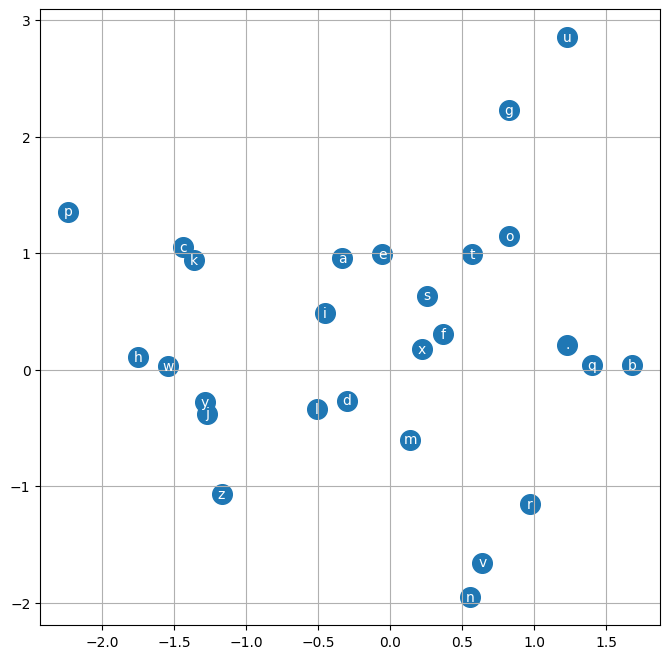

In [42]:
# visualization dimension 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize = (8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [43]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) # for reproducibility

for _ in range(20):
    out = []
    context = [0] * block_size # init as all ....
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, emb_len)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlahna.
briqlihkimriyashty.
sacassalbrrtntsa.
pesrrestreyghn.
kmarthziriiv.
kaleggyus.
matdin.
quinnysslintarivebbuwrletrushartxi.
fryek.
drslynn.
deziiahmilemedss.
kalpassivajncsyadnn.
bosbdelyston.
frinsorenzeplladlyah.
qoebertliannuxahraqnalmytrayd.
xennyxquezbbbbdayl.
kemp.
trubrichlddr.
rissllyzabrcestabnnyxannettdllshatttzsmduevf.
keph.


In [74]:
### Let's train a deeper neuro network
##  The classes we create here are the same API as nn.Module in pyTorch

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.b = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.b is None else [self.b])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalized to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [87]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator = g) 
layers = [
    Linear(block_size * n_embd, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [88]:
epochs = 200000
batch_size = 32
lossi = []
ud = []

for i in range(epochs):
    # minbatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, yb = X_train[ix], y_train[ix]
    
    # forward pass
    emb = C[Xb] # (batch_size, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # (batch_size, block_size * n_embd)
    
    for layer in layers:
        x = layer(x) # forward calculation
    
    loss = F.cross_entropy(x, yb) # loss function
    
    # backward pass
#     for layer in layers:
#         layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    
    for p in parameters:
        p.grad = None  # zero gradients
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < 100000 else 0.001 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log().item() for p in parameters])
    
#     if i > 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization
    

      0/ 200000: 3.2882
  10000/ 200000: 2.4076
  20000/ 200000: 1.9991
  30000/ 200000: 2.0830
  40000/ 200000: 2.3940
  50000/ 200000: 2.6357
  60000/ 200000: 1.6119
  70000/ 200000: 2.4726
  80000/ 200000: 2.0437
  90000/ 200000: 2.2679
 100000/ 200000: 2.0853
 110000/ 200000: 2.1768
 120000/ 200000: 2.1515
 130000/ 200000: 1.9186
 140000/ 200000: 1.8393
 150000/ 200000: 2.0578
 160000/ 200000: 2.2784
 170000/ 200000: 1.9077
 180000/ 200000: 1.8283
 190000/ 200000: 1.9484


layer 2 (      Tanh): mean -0, std 0.71, saturated: 16.12%
layer 5 (      Tanh): mean +0, std 0.75, saturated: 18.12%
layer 8 (      Tanh): mean -0, std 0.76, saturated: 17.94%
layer 11 (      Tanh): mean +0, std 0.77, saturated: 18.47%
layer 14 (      Tanh): mean +0, std 0.78, saturated: 19.53%


Text(0.5, 1.0, 'activation distrubition')

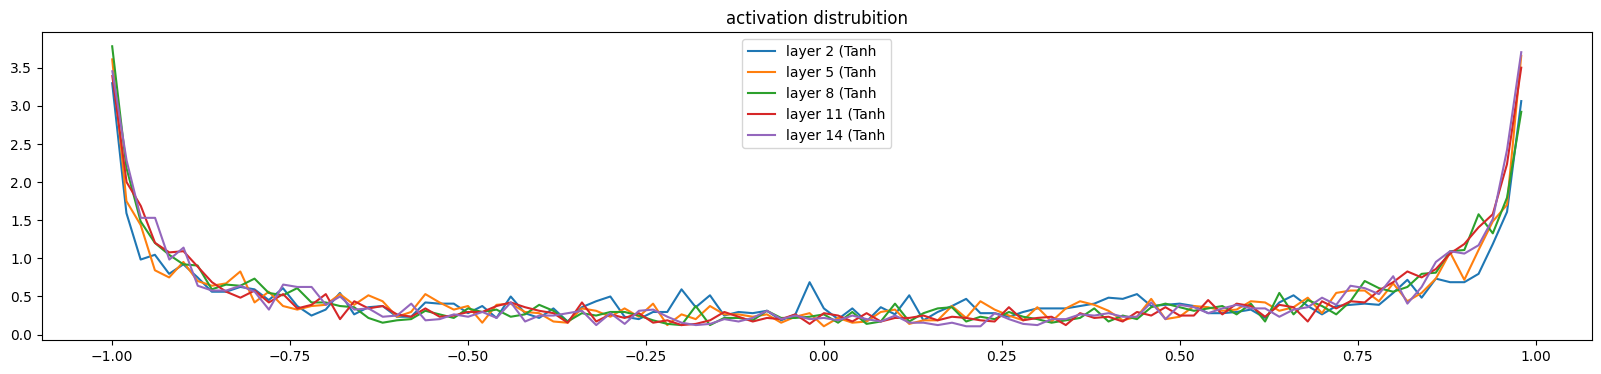

In [89]:
## visualize histograms
plt.figure(figsize = (20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+2.f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distrubition')


In [90]:
# visualize histograms
plt.figure(figsize=(20,4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

C:\Users\xiaoeason\AppData\Local\anaconda3\envs\disk\lib\site-packages\torch\_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\build\aten\src\ATen/core/TensorBody.h:482.)
  return self._grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if t.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [91]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (X_train, y_train),
    'eval': (X_eval, y_eval),
    'test': (X_test, y_test),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('eval')
split_loss('test')

train 2.023681879043579
eval 2.0992696285247803
test 2.0926852226257324


In [92]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amelle.
khyler.
xith.
cassanden.
jazhith.
deliah.
jareei.
nellara.
chaiivia.
legy.
dham.
joce.
quint.
shon.
walianni.
waterri.
jaryxia.
kael.
dura.
